In [1]:
import keras
from keras.layers import Conv3D,MaxPool3D,Flatten, Dense, Reshape
from keras.layers import Dropout, Input,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv


from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [3]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.8
windowSize = 25

In [4]:
def loadData(name):
    
    if name == 'IP':
        data = sio.loadmat('../input/hsi-dataset/Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('../input/hsi-dataset/Indian_pines_gt.mat')['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyLDA(X,y):
    newX=np.reshape(X, (-1, X.shape[2]))
    y=np.reshape(y,(-1,1))
    lda=LDA()
    newX = lda.fit_transform(newX,y.ravel())
    newX = np.reshape(newX, (X.shape[0],X.shape[1],newX.shape[1]))
    return newX

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

In [10]:
 X= applyLDA(X,y)

In [11]:
X.shape

(145, 145, 16)

In [12]:
K = X.shape[2]

K

16

In [13]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 16), (10249,))

In [14]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2049, 25, 25, 16), (8200, 25, 25, 16), (2049,), (8200,))

*MODELING AND TRAINING****

In [15]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2049, 25, 25, 16, 1)

In [16]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(2049, 16)

In [17]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [18]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2) 

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [19]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 16, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 10, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 6, 16)     5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 4, 32)     13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 9, 9, 2, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 2, 32)       128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0   

In [21]:
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [22]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [23]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
2049/2049 [==============================] - 5s 2ms/step - loss: 2.0118 - accuracy: 0.4202

Epoch 00001: accuracy improved from -inf to 0.42020, saving model to best-model.hdf5
Epoch 2/100
2049/2049 [==============================] - 0s 209us/step - loss: 0.6212 - accuracy: 0.7960

Epoch 00002: accuracy improved from 0.42020 to 0.79600, saving model to best-model.hdf5
Epoch 3/100
2049/2049 [==============================] - 0s 209us/step - loss: 0.2763 - accuracy: 0.9092

Epoch 00003: accuracy improved from 0.79600 to 0.90922, saving model to best-model.hdf5
Epoch 4/100
2049/2049 [==============================] - 0s 217us/step - loss: 0.1728 - accuracy: 0.9488

Epoch 00004: accuracy improved from 0.90922 to 0.94876, saving model to best-model.hdf5
Epoch 5/100
2049/2049 [==============================] - 0s 211us/step - loss: 0.1423 - accuracy: 0.9595

Epoch 00005: accuracy improved from 0.94876 to 0.95949, saving model to best-model.hdf5
Epoch 6/100
2049/2049 [============

In [24]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(8200, 25, 25, 16, 1)

In [26]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(8200, 16)

In [27]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.99      0.98      0.98      1143
           2       0.99      0.98      0.98       664
           3       0.96      1.00      0.98       190
           4       0.98      1.00      0.99       386
           5       0.98      0.98      0.98       584
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00       382
           8       0.80      1.00      0.89        16
           9       0.97      1.00      0.98       778
          10       0.99      0.97      0.98      1964
          11       0.98      0.96      0.97       475
          12       1.00      1.00      1.00       164
          13       0.98      1.00      0.99      1012
          14       0.98      1.00      0.99       309
          15       0.89      0.97      0.93        74

    accuracy                           0.98      8200
   macro avg       0.97   

In [28]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [29]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [30]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

8200/8200 [==============================] - 1s 155us/step


In [31]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [32]:
# load the original image
X, y = loadData(dataset)

In [33]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [34]:
X= applyLDA(X,y)

In [35]:
X = padWithZeros(X, PATCH_SIZE//2)

In [36]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

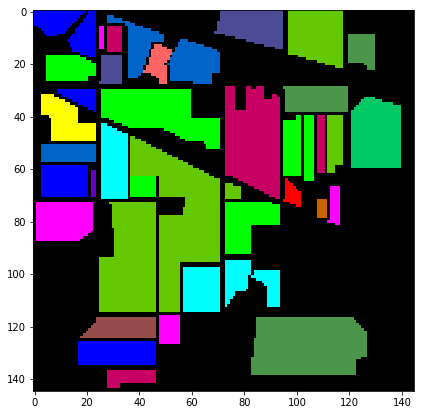

In [37]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

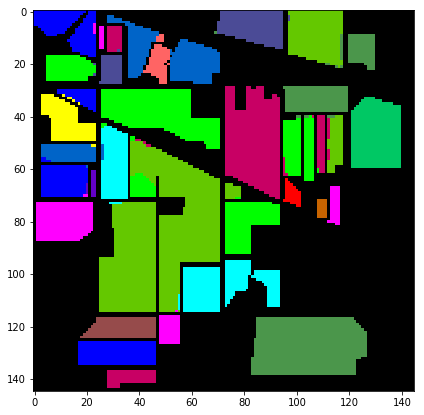

In [38]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [39]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)